## 1- Introduction
In this report, I investigate the Dimethylsulfide (DMS) concentration at sea surface level. 

## 2- Methodology
In this study, we compare the concentration of DMS at the surface Ocean (DMSOS herein) between models and observations in the Arctic regions. For that purpose, we use two models that predicts the DMSOS concentrations, namely: a) CNRM-ESM2-1  and b) UKESM-1-0-LL for the historical period experiment and for different ensembles (5-ensembles), where the mean over the same list of member_id is calculated for both models, repectively. We compared the predicted DMSOS to the observed ones from Vali et al. (2019). The observed DMSOS concentration in Vali et al.(2019) was paramertized based on the observed chlorophyl concentraion from Modis-Aqua and SeaWifs for the periods from 2003 to 2016, and 1998 to 2007, respectively. In this report, we only consider the observed data from Modis-Aqua and compare them with modeling data for the matching period from 2003 to 2014. 

### 2-1 Avialbility of modeling and observational Data
1- Modeling data
The DMSOS concentrations data extracted from the two models for the historical period of different ensembles are listed in the bucket under the directory 'escience2022/Ada/monthly'.
2- Observational data
The DMSOS data extracted from observations are listed under the directory 'escience2022/Antoine/Satellite_Arctic_DMS'.

## 3- Results and Discussion
### 3-1 DMSOS in CMIP6

In [1]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy 
import cartopy.crs as ccrs
import functions
import s3fs
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib as mpl
from scipy.interpolate import griddata
%matplotlib inline
%load_ext autoreload
%autoreload 2
# access and open the bucket
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0",
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [2]:
# list the available modeling data in the bucket
dir = 'escience2022/Ada/monthly'
files = [file for file in s3.ls(dir) if 'dmsos' in file ]

In [3]:
## for UKESM
#list of member-id that we average over
list_member_id = ['1', '2', '3', '4','8','9']
list_ds = []
for imember, member in enumerate(list_member_id):
    remote_files_UK = 's3://escience2022/Ada/monthly/dmsos_Omon_UKESM1-0-LL_historical_r'+member+'*.nc'
    remote_files_UK = s3.glob(remote_files_UK)
    fileset = [s3.open(file) for file in remote_files_UK]
    list_ds.append(xr.open_mfdataset(fileset, combine='by_coords'))
## merge all the ensembles files 
ds_UKESM = xr.concat(list_ds,"member_id")
with ProgressBar():
    ds_dmsos_UKESM = ds_UKESM.dmsos.mean(dim=['member_id']).compute()
#ds_dmsos_UKESM    

[########################################] | 100% Completed | 193.49 s


In [4]:
## for CNRM
#same list of member-id as in UKESM
list_member_id2 = ['1', '2', '3', '4','8','9']
list_ds_CN = []
for imember2, member2 in enumerate(list_member_id2):
    remote_files_CN = 's3://escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r'+member2+'*.nc'
    remote_files_CN = s3.glob(remote_files_CN)
    fileset2 = [s3.open(file) for file in remote_files_CN]
    list_ds_CN.append(xr.open_mfdataset(fileset2,combine="nested",compat="override"))
ds_CNRM = xr.concat(list_ds_CN,"member_id")
with ProgressBar():
    ds_dmsos_CNRM = ds_CNRM.dmsos.mean(dim=['member_id']).compute()
#ds_dmsos_CNRM


[########################################] | 100% Completed | 333.52 s


Here, we choose two contrasting areas of interest for both models to investigate whether DMS surface concentration would be different. Those areas are: a) Greenland Sea (herein GLS) and b) Laptev Sea (herein LPS).
In the following, the mean of DMSOS over the whole historical period is calculated and the resulting maps are plotted for both models over the GLS and LPS areas. 

In [5]:
##  Greenland Sea for UKESM model
dmsosset_GLarea_UKESM = ds_dmsos_UKESM.where((ds_dmsos_UKESM.longitude >= -10)
                                           & (ds_dmsos_UKESM.longitude <= 10) 
                                           & (ds_dmsos_UKESM.latitude <= 85) 
                                           & (ds_dmsos_UKESM.latitude >= 70),
                         drop=True).compute()
## test plotting one time from the data array
#ds_dmsos_UKESM.sel(time=cftime.Datetime360Day(1950, 1, 16, 
#                                                   has_year_zero=True)).plot.contourf(cmap='YlOrRd')


In [6]:
dms_MeanAllHistrorical_UKESM_GL = dmsosset_GLarea_UKESM.mean(dim='time',keep_attrs=True).compute() 
#dms_AnnMeanAllHistrorical_UKESM_GL

In [7]:
## Laptev sea for UKESM
dmsosset_LapSarea_UKESM = ds_dmsos_UKESM.where((ds_dmsos_UKESM.longitude>=100) 
                                       & (ds_dmsos_UKESM.longitude<=160) 
                                       & (ds_dmsos_UKESM.latitude <= 80)  
                                       & (ds_dmsos_UKESM.latitude >= 70),
                         drop=True).compute()
#dmsosset_LapSarea_UKESM.sel(time=cftime.Datetime360Day(1950, 1, 16, 
#                                                   has_year_zero=True)).plot.contourf(cmap='YlOrRd')

In [8]:
dms_MeanAllHistrorical_UKESM_LapS = dmsosset_LapSarea_UKESM.mean(dim='time',
                                                                    keep_attrs=True).compute() 
#dms_AnnMeanAllHistrorical_UKESM_LapS

In [9]:
# Greenland Sea for CNRM model
dmsosset_GLarea_CNRM = ds_dmsos_CNRM.where((ds_dmsos_CNRM.lon >= -10)
                                           & (ds_dmsos_CNRM.lon <= 10) 
                                           & (ds_dmsos_CNRM.lat <= 85) 
                                           & (ds_dmsos_CNRM.lat >= 70),
                         drop=True).compute()
## test plotting one time from the data array
#dmsset_GLarea_CNRM.sel(time='1850-02-16T12:00:00.000000000',
#                       method='nearest').plot.contourf(cmap='YlOrRd')

In [10]:
dms_MeanAllHistrorical_CNRM_GL = dmsosset_GLarea_CNRM.mean(dim='time',keep_attrs=True).compute() 
#dms_AnnMeanAllHistrorical_CNRM_GL

In [11]:
# Laptev Sea Sea for CNRM model
dmsosset_LapSarea_CNRM = ds_dmsos_CNRM.where((ds_dmsos_CNRM.lon >= 100)
                                           & (ds_dmsos_CNRM.lon <= 160) 
                                           & (ds_dmsos_CNRM.lat <= 80) 
                                           & (ds_dmsos_CNRM.lat >= 70),
                         drop=True).compute()
## test plotting one time from the data array
#dmsset_LapSarea_CNRM.sel(time='1850-02-16T12:00:00.000000000',method='nearest').plot.contourf(cmap='YlOrRd')

In [12]:
dms_MeanAllHistrorical_CNRM_LapS = dmsosset_LapSarea_CNRM.mean(dim='time',keep_attrs=True).compute() 
#dms_AnnMeanAllHistrorical_CNRM_LapS

/tmp/ipykernel_4049/2802919834.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


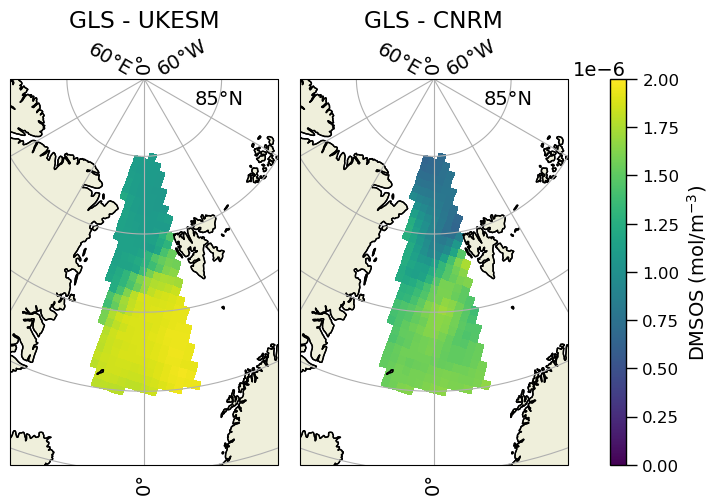

In [13]:
mpl.rcParams.update({'font.size':14})
fig, ax = plt.subplots(1,2,figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax[0].set_extent([-20, 20,65,90], ccrs.PlateCarree())
ax[1].set_extent([-20, 20,65,90], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_MeanAllHistrorical_UKESM_GL.longitude,
                       dms_MeanAllHistrorical_UKESM_GL.latitude,
              dms_MeanAllHistrorical_UKESM_GL, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('GLS - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()

pl_CNRM=ax[1].pcolormesh(dms_MeanAllHistrorical_CNRM_GL.lon,
                       dms_MeanAllHistrorical_CNRM_GL.lat,
              dms_MeanAllHistrorical_CNRM_GL, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('GLS - CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[1],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_UKESM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMSOS (mol/m$^{-3}$)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('Fig1_DMS_SurfConc_UKESM_vs_CNRM_Greenland_HistoricalAvrg_report.png')

###### Fig1: Comparing the Maps distribution of the mean over the whole historical period of DMSOS in the Greenland Sea area predicted by a) UKESM (left) and b) CNRM (right) models

/tmp/ipykernel_4049/1876244678.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


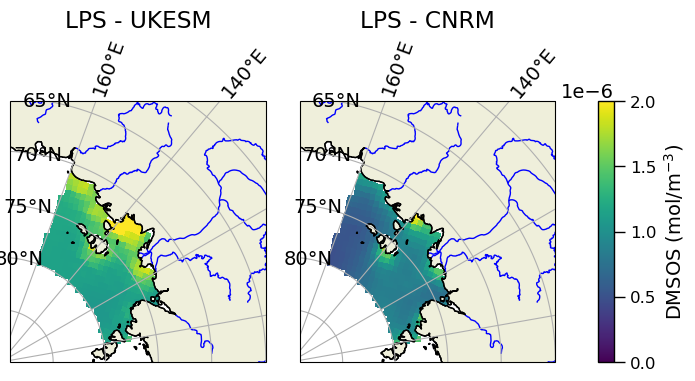

In [14]:
mpl.rcParams.update({'font.size':14})
fig, ax = plt.subplots(1,2,figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax[0].set_extent([90,170,65,85], ccrs.PlateCarree())
ax[1].set_extent([90,170,65,85], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_MeanAllHistrorical_UKESM_LapS.longitude,
                       dms_MeanAllHistrorical_UKESM_LapS.latitude,
              dms_MeanAllHistrorical_UKESM_LapS, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('LPS - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()
ax[0].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')

pl_CNRM=ax[1].pcolormesh(dms_MeanAllHistrorical_CNRM_LapS.lon,
                       dms_MeanAllHistrorical_CNRM_LapS.lat,
              dms_MeanAllHistrorical_CNRM_LapS, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('LPS - CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
ax[1].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[1],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_UKESM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMSOS (mol/m$^{-3}$)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('Fig2_DMS_SurfConc_UKESM_vs_CNRM_LaptevSea_HistoricalAvrg_report.png')

###### Fig2: Comparing the Maps distribution of the mean over the whole historical period of DMSOS in the Laptev Sea area predicted by a) UKESM (left) and b) CNRM (right) models

Figures 1, 2 diplays the distribution of the mean DMSOS concentration over the historical period from 1850 to 2014 for the two arctic regions GLS and LPS, respectively. In both regions, the DMSOS predicted by UKESM was larger than CNRM; being factor of ~ 2 to 3. This difference can be due to the different parametrizations that are used to estimate the DMSOS concentrations as well as to the different spatial resolution in both models. 

### 3-2 Comparing DMSOS predicted by CMIP6 to Observations 

To compare with observations, we work with the observational data only for the matching period that extend from 2003 to 2014.

In [15]:
#list the available observational data in the bucket
s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
remote_files = s3.glob(s3files)
fileset = [s3.open(file) for file in remote_files]
ds_obs = xr.open_mfdataset(fileset, combine='by_coords')

Note1: The observational data of DMSOS are incremented differently to the modeling data, where periods of 8 days are considered instead of normal daily or montly periods in models. Therefore, we used the following method to add date and transform the periods of 8 days into month.

In [16]:
## add date to the observational data
import datetime
dates = np.array([
    [datetime.datetime(int(y.values), 1, 1) + datetime.timedelta(d.values - 1) for d in ds_obs.startjulday.sel(year=y)] 
        for y in ds_obs.year])

ds_obs=ds_obs.assign_coords({ "d": (['year','period'],dates ) })
ds_obs=ds_obs.stack(time=['year','period'])
ds_obs=ds_obs.set_index(time='d')
ds_obs

<xarray.Dataset>
Dimensions:      (pixel: 96668, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>
    latitude     (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>
    startjulday  (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    endjulday    (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>

In [17]:
## Greenland Sea for Observations
DmsObs_GLSarea = ds_obs.where((ds_obs.longitude>=-10) & (ds_obs.longitude<=10) 
                           & (ds_obs.latitude <= 85)  & (ds_obs.latitude >= 70),
                         drop=True).compute()
DmsObs_GLSarea

<xarray.Dataset>
Dimensions:      (pixel: 1033, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.918 -9.918 -9.918 ... 8.372 8.372
    latitude     (pixel, time) float64 70.12 70.12 70.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan nan ... nan nan nan nan

In [18]:
## we select the period from 2003 to 2014 and ignore the the last two years
dmsObs_2003to2014_GLS = DmsObs_GLSarea.isel(time= slice(552))
dmsObs_2003to2014_GLS

<xarray.Dataset>
Dimensions:      (pixel: 1033, time: 552)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year         (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.918 -9.918 -9.918 ... 8.372 8.372
    latitude     (pixel, time) float64 70.12 70.12 70.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan nan ... nan nan nan nan

In [19]:
# calculate the mean over 2003 to 2014
dmsObs_Mean_2003to2014_GLS = dmsObs_2003to2014_GLS.mean(dim='time').compute() 
dmsObs_Mean_2003to2014_GLS

<xarray.Dataset>
Dimensions:      (pixel: 1033)
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 -9.918 -9.184 -8.449 ... 2.791 5.581 8.372
    latitude     (pixel) float64 70.12 70.12 70.12 70.12 ... 84.88 84.88 84.88
    startjulday  (pixel) float64 181.0 181.0 181.0 181.0 ... 181.0 181.0 181.0
    endjulday    (pixel) float64 187.9 187.9 187.9 187.9 ... 187.9 187.9 187.9
    dms          (pixel) float64 1.927 2.022 2.042 1.936 ... nan nan nan nan

In [20]:
## Laptev Sea
DmsObs_LapSarea = ds_obs.where((ds_obs.longitude>=100) & (ds_obs.longitude<=160) 
                           & (ds_obs.latitude <= 80)  & (ds_obs.latitude >= 70),
                         drop=True).compute()
DmsObs_LapSarea

<xarray.Dataset>
Dimensions:      (pixel: 2485, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 100.3 100.3 100.3 ... 159.4 159.4 159.4
    latitude     (pixel, time) float64 70.12 70.12 70.12 ... 79.88 79.88 79.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan nan ... nan nan nan nan

In [21]:
## we select the period from 2003 to 2014 and ignore the the last two years
dmsObs_2003to2014_LapS = DmsObs_LapSarea.isel(time= slice(552))
dmsObs_2003to2014_LapS

<xarray.Dataset>
Dimensions:      (pixel: 2485, time: 552)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year         (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 100.3 100.3 100.3 ... 159.4 159.4 159.4
    latitude     (pixel, time) float64 70.12 70.12 70.12 ... 79.88 79.88 79.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan nan ... nan nan nan nan

In [22]:
dmsObs_Mean_2003to2014_LapS = dmsObs_2003to2014_LapS.mean(dim='time').compute() 
#.compute does the excution of the mean operation
dmsObs_Mean_2003to2014_LapS



<xarray.Dataset>
Dimensions:      (pixel: 2485)
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 100.3 101.0 101.8 102.5 ... 156.5 157.9 159.4
    latitude     (pixel) float64 70.12 70.12 70.12 70.12 ... 79.88 79.88 79.88
    startjulday  (pixel) float64 181.0 181.0 181.0 181.0 ... 181.0 181.0 181.0
    endjulday    (pixel) float64 187.9 187.9 187.9 187.9 ... 187.9 187.9 187.9
    dms          (pixel) float64 nan nan nan nan nan ... 1.337 2.245 1.852 1.764

Note2: The coordinates system of these observations are indexed with pixels instead of (x,y) or (i,j) system. Therefore, we use the following function 'interGali' from the Functions.py to transform the coordinate system and make the DMSOS from observations comparable with CMIP6 modeling data.  

In [23]:
from scipy.interpolate import griddata
def interGali(ds,var):
    '''
        Interploting data on a regular lat,lon grid
        grid is built from latitudes and the longitudes on the lowest latitude
        Input : 
            ds : xarray dataset with latitude, longitude and variable "var" to be interpolated. 
                var, lat,long must be 1d (ie. not depend on time)
            var : string name of variable
        Returns a xarray dataArray with the gridded variable and lat lon as coords
    '''    
    # sorting according to latitudes
    lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values]).sortlevel(level=0)[0] 
    # get longitudes of lowest latitude
    lowlat = lalo.values[0][0]
    lon1d = np.array([x[1] for x in lalo.values if x[0]==lowlat])
    # get latitudes
    lat1d = np.unique(ds.latitude.values)
    # Building regular grid of lat and lon
    lon, lat = np.meshgrid(lon1d,lat1d)

    # interpolation
    var_gridded =griddata(
            (ds.longitude.values, ds.latitude.values), #points
            ds[var].values, #data
            (lon, lat), #grid on which to interpolate
            method='nearest')
    
    return  xr.DataArray(
        var_gridded,
        dims=("lat","lon"),
        coords={
            "lat": lat1d,
            "lon": lon1d
        }
    )

In [25]:
dmsObs_Mean_2003to2014_GLS = interGali(dmsObs_Mean_2003to2014_GLS, 'dms')

In [26]:
dmsObs_Mean_2003to2014_LapS = interGali(dmsObs_Mean_2003to2014_LapS, 'dms')
dmsObs_Mean_2003to2014_LapS

<xarray.DataArray (lat: 40, lon: 82)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        7.89935662],
       ...,
       [1.43696065, 1.4629335 , 1.34438606, ..., 1.79688805, 1.77197742,
        1.57463421],
       [1.43696065, 1.14528239, 1.34438606, ..., 1.79688805, 1.77197742,
        1.57463421],
       [1.43696065, 1.14528239, 1.34438606, ..., 1.79688805, 1.7643332 ,
        1.57463421]])
Coordinates:
  * lat      (lat) float64 70.12 70.38 70.62 70.88 ... 79.12 79.38 79.62 79.88
  * lon      (lon) float64 100.3 101.0 101.8 102.5 ... 157.6 158.3 159.1 159.8

In [27]:
dms_Mean2003to2014_GLS_UKESM = dmsosset_GLarea_UKESM.isel(time = slice(1836,None)).mean(dim='time',
                                                        keep_attrs=True).compute()

In [28]:
dms_Mean2003to2014_GLS_CNRM = dmsosset_GLarea_CNRM.isel(time = slice(1836,None)).mean(dim='time',
                                                        keep_attrs=True).compute()

In [29]:
dms_Mean2003to2014_LapS_UKESM = dmsosset_LapSarea_UKESM.isel(time = slice(1836,None)).mean(dim='time',
                                                        keep_attrs=True).compute()

In [30]:
dms_Mean2003to2014_LapS_CNRM = dmsosset_LapSarea_CNRM.isel(time = slice(1836,None)).mean(dim='time',
                                                        keep_attrs=True).compute()

In [38]:
dmsObs_Mean_2003to2014_LapS[3].mean()


<xarray.DataArray ()>
array(4.81064384)
Coordinates:
    lat      float64 70.88

In [48]:
dms_Mean2003to2014_GLS_CNRM[3].max()

<xarray.DataArray 'dmsos' ()>
array(1.66082054e-06)
Coordinates:
    depth    float64 0.0

/tmp/ipykernel_4049/3583597229.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


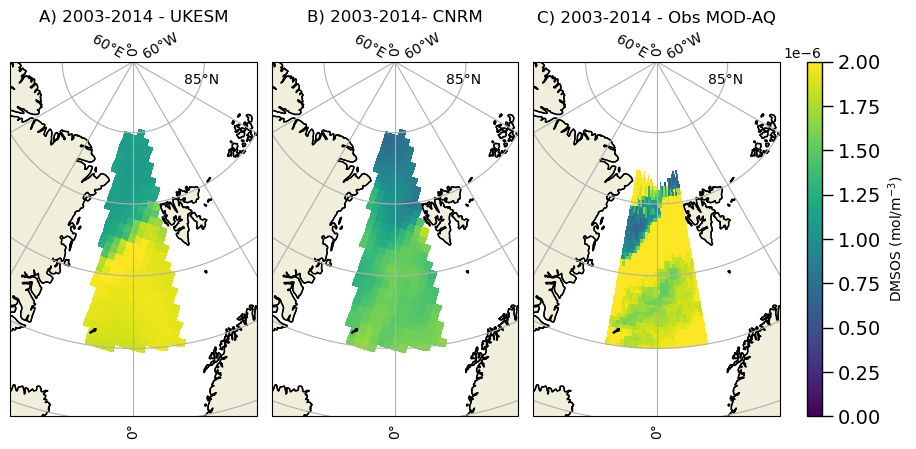

In [40]:
mpl.rcParams.update({'font.size':10})
fig, ax = plt.subplots(1,3,figsize=(8,8),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax[0].set_extent([-20, 20,65,90], ccrs.PlateCarree())
ax[1].set_extent([-20, 20,65,90], ccrs.PlateCarree())
ax[2].set_extent([-20, 20,65,90], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_Mean2003to2014_GLS_UKESM.longitude,
                       dms_Mean2003to2014_GLS_UKESM.latitude,
              dms_Mean2003to2014_GLS_UKESM, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('A) 2003-2014 - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()
ax[0].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')
pl_CNRM=ax[1].pcolormesh(dms_Mean2003to2014_GLS_CNRM.lon,
                         dms_Mean2003to2014_GLS_CNRM.lat,
                         dms_Mean2003to2014_GLS_CNRM, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('B) 2003-2014- CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
ax[1].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')

pl_Obs=ax[2].pcolormesh(dmsObs_Mean_2003to2014_GLS.lon,
                        dmsObs_Mean_2003to2014_GLS.lat,
                        dmsObs_Mean_2003to2014_GLS*1.0e-6,
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[2].set_title('C) 2003-2014 - Obs MOD-AQ')
ax[2].gridlines(draw_labels=True)
ax[2].coastlines()
ax[2].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[2],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_UKESM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_Obs, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMSOS (mol/m$^{-3}$)')

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('Fig3_DMS_SurfConc_UKESM_vs_CNRM_vs_Obs_GreenlandSea_2003to2014Avrg.png')

/tmp/ipykernel_4049/1383539625.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


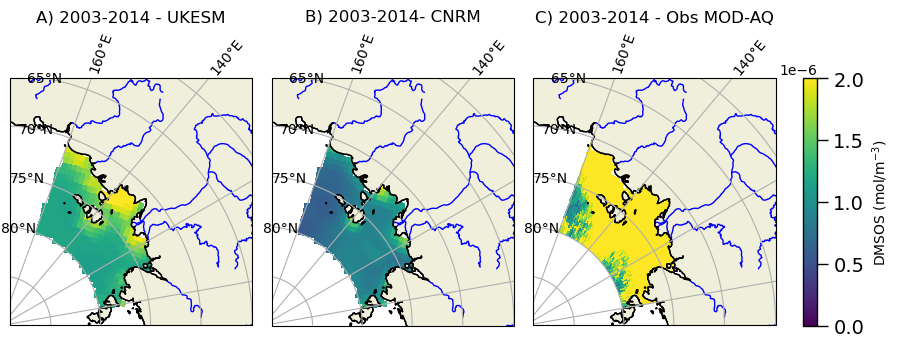

In [32]:
mpl.rcParams.update({'font.size':10})
fig, ax = plt.subplots(1,3,figsize=(8,8),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax[0].set_extent([90,170,65,85], ccrs.PlateCarree())
ax[1].set_extent([90,170,65,85], ccrs.PlateCarree())
ax[2].set_extent([90,170,65,85], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_Mean2003to2014_LapS_UKESM.longitude,
                       dms_Mean2003to2014_LapS_UKESM.latitude,
              dms_Mean2003to2014_LapS_UKESM, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('A) 2003-2014 - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()
ax[0].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')
pl_CNRM=ax[1].pcolormesh(dms_Mean2003to2014_LapS_CNRM.lon,
                         dms_Mean2003to2014_LapS_CNRM.lat,
                         dms_Mean2003to2014_LapS_CNRM, 
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('B) 2003-2014- CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
ax[1].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')

pl_Obs=ax[2].pcolormesh(dmsObs_Mean_2003to2014_LapS.lon,
                        dmsObs_Mean_2003to2014_LapS.lat,
                        dmsObs_Mean_2003to2014_LapS*1.0e-6,
    vmin=0,vmax=2.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[2].set_title('C) 2003-2014 - Obs MOD-AQ')
ax[2].gridlines(draw_labels=True)
ax[2].coastlines()
ax[2].add_feature(cartopy.feature.RIVERS, zorder=1, edgecolor='blue')
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[2],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_UKESM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_Obs, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMSOS (mol/m$^{-3}$)')

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('Fig4_DMS_SurfConc_UKESM_vs_CNRM_vs_Obs_LaptevSea_2003to2014Avrg.png')

###### Fig4:Comparing the Maps distribution of the mean over the matching period (2003-2014) of DMSOS in the Laptev Sea area predicted by A) UKESM and B) CNRM models, and C) observations from Modis-Aqua (Gali et al. (2019)) 

During the matching period between 2003 and 2004 and over the GLS and LPS areas, UKESM still predicts larger DMSOS mean concentration than CNRM (factor of ~ 2) as illustarted in Figures 3 and 4. However, both models predicts less DMSOS mean concentrations than what has been observed (factor of ~ 4 in many spots) for both GLS and LPS areas and in general over the whole Arctic. In addition,  the observed DMSOS mean over the LPS domain during the matching period is higher than what is observed in the GLS domain. This might be explained by the more decrease of sea ice content (sea ice melting) during the recent years due to climate change in the Arctic region, which has more influence on the LPS domain than GLS, which is more represented by open Ocean. The observed DMSOS mean over the LPS domain is 4.8 umol/m-3 in comparison to 1.0 and 1.82 umol/m-3 for CNRM and UKESM, respectively. In contrary, the DMSOS mean over the GLS domain during the same matching period is comparable between both models and observations; being 2.4, 1.94, 1.7 umol/m-3 for observation, UKESM, and CNRM, respectively.  Once again, this difference between observation and models can be explained by the higher spatial and temporal resolution that observations possess; being 28 km.

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


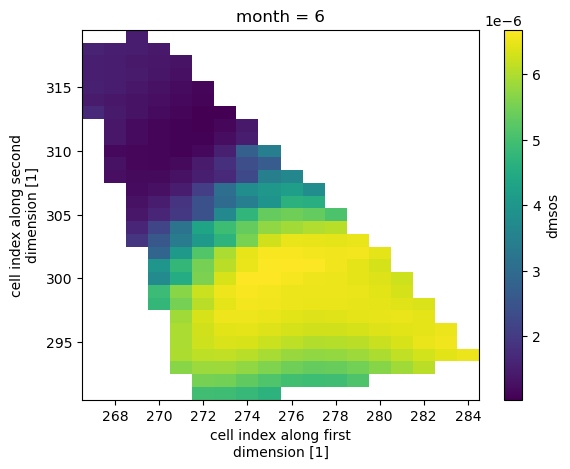

In [34]:
dms_MonMeanAllHistrorical_UKESM_GL = dmsosset_GLarea_UKESM.groupby('time.month').mean(dim='time',
                                                              keep_attrs=True).compute() 

dms_MonMeanAllHistrorical_UKESM_GL[5].plot()


NameError: name 'dms_AnnMeanAllHistrorical_CNRM_LapS' is not defined

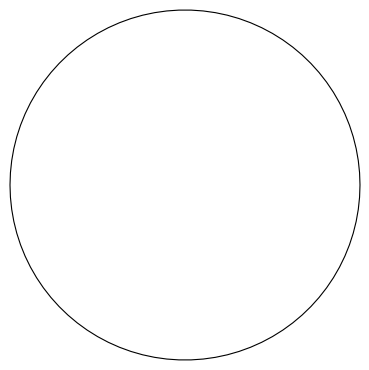

In [35]:
# Create figure 4
#import Functions as f

extent = [100,160, 80, 70]
fig = plt.figure(1, figsize=[10,10])
ax = plt.subplot(2, 2, 1, projection=ccrs.NorthPolarStereo())
#f.mapfeatures(ax,extent)
ax = dms_AnnMeanAllHistrorical_CNRM_LapS.plot.pcolormesh(x='lon', y='lat', 
    cmap='PiYG_r', vmax = 2.0e-6, vmin = 0,
    transform = ccrs.PlateCarree(), 
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('A: 1850-2014 CNRM')

ax = plt.subplot(2, 2, 2, projection=ccrs.NorthPolarStereo() )
#f.mapfeatures(ax,extent)
ax = dms_AnnMeanAllHistrorical_UKESM_LapS.plot.pcolormesh(x='longitude', y='latitude', 
    cmap='PiYG_r', vmax = 2.0e-6, vmin = 0,
    transform = ccrs.PlateCarree(), 
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('B: 1850-2014 UKESM')

In [ ]:
dmsset_GLarea_UKESM